In [6]:
!pip install xgboost



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
from xgboost import XGBClassifier
# Load processed datasets
df_train = pd.read_csv("train_data_with_traffic_class.csv")
df_test = pd.read_csv("test_data_with_traffic_class.csv")

print(df_train.head())

   Month  Year         Country  Departures  Arrivals  Total Holidays  \
0      1  2000          France     11098.0   11469.0        1.014816   
1      1  2000          Europe    118255.0  119735.0        1.014816   
2      1  2000   North America     29012.0   26225.0        1.014816   
3      1  2000  United Kingdom     46677.0   45630.0        1.014816   
4      1  2000         Germany     23172.0   24251.0        1.014816   

   Inflation  Month_sin  Month_cos  Total_Traffic  Traffic_Class  
0  -0.279182        0.5   0.866025        22567.0              0  
1  -0.279182        0.5   0.866025       237990.0              0  
2  -0.279182        0.5   0.866025        55237.0              0  
3  -0.570839        0.5   0.866025        92307.0              0  
4  -0.395845        0.5   0.866025        47423.0              0  


In [5]:
# Define target and features
X = df_train.drop(columns=["Total_Traffic", "Departures", "Arrivals", "Traffic_Class", "Month"])  # Features
# Encode categorical variables
X = pd.get_dummies(X, columns=["Country"], drop_first=True)  # One-hot encoding
y = df_train["Traffic_Class"]  # Target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 

# Initialize LabelEncoder
#label_encoder = LabelEncoder()

# Apply LabelEncoder to the 'Country' column before scaling
#X["Country"] = label_encoder.fit_transform(X["Country"])
# One-hot encoding (avoids issues if test has missing categories)


# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Initialize XGBoost classifier
xgb_clf = xgb.XGBClassifier()

# Fit the model
xgb_clf.fit(X_train, y_train)

# Predict
y_pred = xgb_clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))


Accuracy: 0.9778523489932885
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1130
           1       0.96      0.98      0.97        53
           2       0.94      0.95      0.95       307

    accuracy                           0.98      1490
   macro avg       0.97      0.97      0.97      1490
weighted avg       0.98      0.98      0.98      1490



In [6]:
# Define target and features
X_test2 = df_test.drop(columns=["Total_Traffic", "Departures", "Arrivals", "Traffic_Class", "Month"])  # Features
y_test2 = df_test["Traffic_Class"]  # Target

# Encode categorical variables
X_test2 = pd.get_dummies(X_test2, columns=["Country"], drop_first=True)  


X_test_scaled = scaler.transform(X_test2)

# Extract true labels
y_test2 = df_test["Traffic_Class"]  # Make sure this column exists in test_data.csv

# Predict and evaluate
y_pred2 = xgb_clf.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test2, y_pred2))

Accuracy: 0.6792873051224945


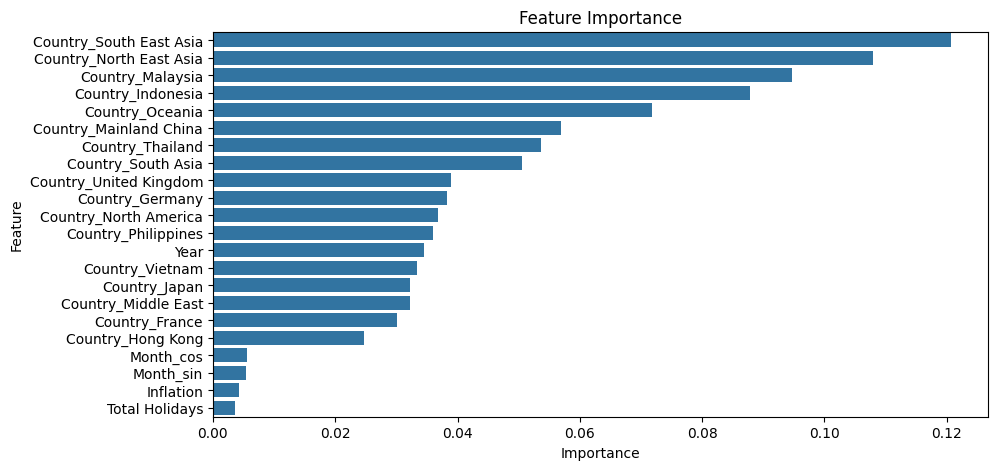

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance
feature_importance = xgb_clf.feature_importances_

# Create a DataFrame for visualization
feat_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feat_df)
plt.title("Feature Importance")
plt.show()


In [8]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize the XGBClassifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV on training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best accuracy score
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

# Train the best model on the full training set
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train)

# Use the best model found by grid search to make predictions
y_train_pred = best_xgb.predict(X_train)
y_test_pred = best_xgb.predict(X_test_scaled)

# Evaluate accuracy and balanced accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test2, y_test_pred)

train_balanced_acc = balanced_accuracy_score(y_train, y_train_pred)
test_balanced_acc = balanced_accuracy_score(y_test2, y_test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

print(f"Train Balanced Accuracy: {train_balanced_acc:.4f}")
print(f"Test Balanced Accuracy: {test_balanced_acc:.4f}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\Vianiece\Desktop\INF2008 Machine Learning\traveltrends\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:49:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
Best accuracy: 0.9700818655420491
Train Accuracy: 0.9934
Test Accuracy: 0.6927
Train Balanced Accuracy: 0.9923
Test Balanced Accuracy: 0.5582


In [9]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [10]:
xgb_clf = xgb.XGBClassifier(random_state=42)

# Fit the model
xgb_clf.fit(X_train_res, y_train_res)

# Predict
y_pred = xgb_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.974496644295302


Test Accuracy: 0.6971
Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78       229
           1       1.00      0.35      0.52        43
           2       0.91      0.39      0.55       177

    accuracy                           0.70       449
   macro avg       0.85      0.58      0.61       449
weighted avg       0.78      0.70      0.66       449



<Axes: >

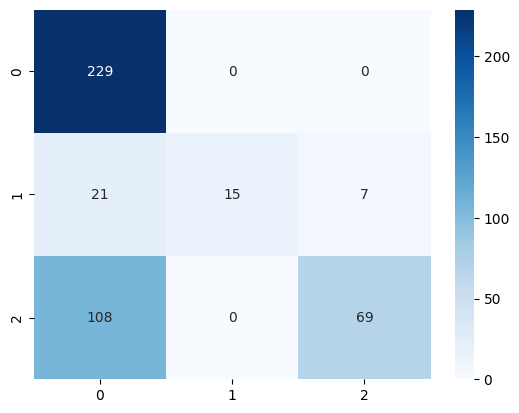

In [11]:
# Predict on the test set
y_pred_resampled = xgb_clf.predict(X_test_scaled)

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Accuracy
print(f"Test Accuracy: {accuracy_score(y_test2, y_pred_resampled):.4f}")

# Classification report
print("Classification Report:")
print(classification_report(y_test2, y_pred_resampled))

# Confusion Matrix
cm = confusion_matrix(y_test2, y_pred_resampled)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])


Fine-Tuning the Hyperparameters of XGBoost:


In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report
import xgboost as xgb

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [3, 5, 7],  # Tree depth
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'subsample': [0.8, 1.0],  # Row sampling
    'colsample_bytree': [0.8, 1.0]  # Feature sampling
}

# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all available CPU cores
)

# Fit GridSearchCV on SMOTE-resampled training data
grid_search.fit(X_train_res, y_train_res)

# Print the best parameters and best accuracy score
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

# Use the best model found by GridSearchCV
best_xgb = grid_search.best_estimator_

# Predict on the SMOTE-resampled training set and the test set
y_train_pred = best_xgb.predict(X_train_res)
y_test_pred = best_xgb.predict(X_test_scaled)  

# Evaluate accuracy and balanced accuracy
train_acc = accuracy_score(y_train_res, y_train_pred)
test_acc = accuracy_score(y_test2, y_test_pred)

train_balanced_acc = balanced_accuracy_score(y_train_res, y_train_pred)
test_balanced_acc = balanced_accuracy_score(y_test2, y_test_pred)

# Print out the results
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

print(f"Train Balanced Accuracy: {train_balanced_acc:.4f}")
print(f"Test Balanced Accuracy: {test_balanced_acc:.4f}")

# Print classification report
print(f"Classification Report:\n{classification_report(y_test2, y_test_pred)}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\Vianiece\Desktop\INF2008 Machine Learning\traveltrends\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:06:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best accuracy: 0.9870103710454586
Train Accuracy: 1.0000
Test Accuracy: 0.6860
Train Balanced Accuracy: 1.0000
Test Balanced Accuracy: 0.5643
Classification Report:
              precision    recall  f1-score   support

           0       0.63      1.00      0.77       229
           1       1.00      0.33      0.49        43
           2       0.92      0.37      0.52       177

    accuracy                           0.69       449
   macro avg       0.85      0.56      0.60       449
weighted avg       0.78      0.69      0.65       449



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report

# DefinXGBoost parameter grid
param_dist = {
    "n_estimators": [50, 75, 100],  # Number of trees
    "max_depth": [5, 10, 15],  # Tree depth
    "learning_rate": [0.01, 0.05, 0.1],  # Learning rate
    "subsample": [0.7, 0.8, 0.9],  # Row sampling
    "colsample_bytree": [0.7, 0.8, 0.9],  # Feature sampling
    "gamma": [0, 0.1, 0.2],  # Pruning
    "lambda": [1, 2, 3],  # L2 regularization
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    n_iter=20,  # Number of random samples
    random_state=42
)

# Fit RandomizedSearchCV on the resampled dataset
random_search.fit(X_train_res, y_train_res)

# Get the best parameters and the best model
print(f"Best Hyperparameters: {random_search.best_params_}")

# Use the best model found by RandomizedSearchCV
best_xgb = random_search.best_estimator_

# Predict on training and test set
y_train_pred = best_xgb.predict(X_train_res)
y_test_pred = best_xgb.predict(X_test_scaled)

# Calculate accuracy and balanced accuracy for train and test set
train_acc = accuracy_score(y_train_res, y_train_pred)
test_acc = accuracy_score(y_test2, y_test_pred)

train_balanced_acc = balanced_accuracy_score(y_train_res, y_train_pred)
test_balanced_acc = balanced_accuracy_score(y_test2, y_test_pred)

# Print out the results
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Train Balanced Accuracy: {train_balanced_acc:.4f}")
print(f"Test Balanced Accuracy: {test_balanced_acc:.4f}")

# Print classification report for the test set
print(f"Classification Report:\n{classification_report(y_test2, y_test_pred)}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'lambda': 1, 'gamma': 0.2, 'colsample_bytree': 0.8}
Train Accuracy: 0.9982
Test Accuracy: 0.6815
Train Balanced Accuracy: 0.9982
Test Balanced Accuracy: 0.5957
Classification Report:
              precision    recall  f1-score   support

           0       0.63      1.00      0.77       229
           1       1.00      0.47      0.63        43
           2       0.89      0.32      0.47       177

    accuracy                           0.68       449
   macro avg       0.84      0.60      0.63       449
weighted avg       0.77      0.68      0.64       449

